### Use `RGBD` camera

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
# from pyntcloud import PyntCloud
import sys
sys.path.append('../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,compute_view_params,get_interp_const_vel_traj
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Parse `UR5e` with `RG2` gripper

In [2]:
xml_path = '../../asset/ur5e/scene_ur5e_rg2_d435i_obj_realworld.xml'
# xml_path = '../../asset/ur5e/scene_ur5e_rg2_d435i_vbm.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)

obj_cylinder_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_cylinder"))]
obj_box_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_box"))]
obj_glass_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_wine"))]

n_cylinder_obj = 3 # len(obj_cylinder_names)
n_box_obj = 3 # len(obj_box_names)
n_glass_obj = 3 # len(obj_glass_names)

# Place objects
env.place_objects(n_obj=3, obj_names=obj_cylinder_names, x_range=[0.75, 0.85], y_range=[-0.15, 0.15], COLORS=True, VERBOSE=True)
# env.place_objects(n_obj=3, obj_names=obj_box_names, COLORS=True, VERBOSE=True) 
env.place_objects(n_obj=3, obj_names=obj_glass_names, COLORS=False, VERBOSE=True)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([0.38+0.6,0,0])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-0.05,0.80,0])
env.model.body('base').pos = np.array([0.18,0,0.79])


print ("Ready.")

dt:[0.0020] HZ:[500]
n_dof (=nv):[60]
n_geom:[62]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'front_object_table', 'right_object_table', 'left_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05', 'obj_cylinder_06', 'obj_cylinder_07', 'obj_cylinder_08']
n_body:[31]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'd435i', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle

### Render

In [29]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Base pose
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')

# Straight pose
DO_RENDER_IK = True
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,0,0]))@rpy2r(np.radians([-180,0,90]))
q_prepose_00 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=1,th=1*np.pi/180.0,err_th=1e-2)

# 60 deg down pose
p_trgt = p_base + np.array([0.5,-0.4,0.3])
R_trgt = rpy2r(np.radians([0,60,0]))@rpy2r(np.radians([-180,0,90]))
q_prepose_60 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_00,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=1,th=1*np.pi/180.0,err_th=1e-4)

env.close_viewer()
print ("IK done.")

IK done.


In [30]:
def trapezoidal_spline(q_init, q_final, max_velocity, max_acceleration):
    delta = q_final - q_init
    t_accel = max_velocity / max_acceleration
    x_accel = 0.5 * max_acceleration * t_accel ** 2

    if delta >= 2 * x_accel: # Case where there is a constant velocity phase
        t_constant = (abs(delta) - 2 * x_accel) / max_velocity
    else: # Case where there is no constant velocity phase
        t_constant = 0
        t_accel = np.sqrt(abs(delta) / max_acceleration)

    t_total = 2 * t_accel + t_constant

    # Time vector
    t = np.linspace(0, t_total, 1000)

    # Position function
    q = np.zeros_like(t)
    mask1 = t < t_accel
    mask2 = (t >= t_accel) & (t < t_accel + t_constant)
    mask3 = t >= t_accel + t_constant

    if q_final > q_init: # Start with acceleration
        q[mask1] = q_init + 0.5 * max_acceleration * t[mask1] ** 2
        q[mask2] = q_init + x_accel + max_velocity * (t[mask2] - t_accel)
        q[mask3] = q_final - 0.5 * max_acceleration * (t_total - t[mask3]) ** 2
    else: # Start with deceleration
        q[mask1] = q_init - 0.5 * max_acceleration * t[mask1] ** 2
        q[mask2] = q_init - x_accel - max_velocity * (t[mask2] - t_accel)
        q[mask3] = q_final + 0.5 * max_acceleration * (t_total - t[mask3]) ** 2

    return q, t


In [31]:
import matplotlib.pyplot as plt

q_init = np.array(np.radians([0, -90, 90, 0, 0, 0]))
q_final = q_prepose_60
max_velocities = np.ones(6) * 10
max_accelerations = np.ones(6) * 10

# Generate trapezoidal splines for each joint and plot
q_list = []
for joint, (_q_init, _q_final, v_max, a_max) in enumerate(zip(q_init, q_final, max_velocities, max_accelerations)):
    q, t = trapezoidal_spline(_q_init, _q_final, v_max, a_max)
    q_list.append(q)
    accel_or_decel = "acceleration" if _q_init > _q_init else "deceleration"
    print(f"Joint {joint+1} starts with {accel_or_decel}")

q_list = np.array(q_list)

Joint 1 starts with deceleration
Joint 2 starts with deceleration
Joint 3 starts with deceleration
Joint 4 starts with deceleration
Joint 5 starts with deceleration
Joint 6 starts with deceleration


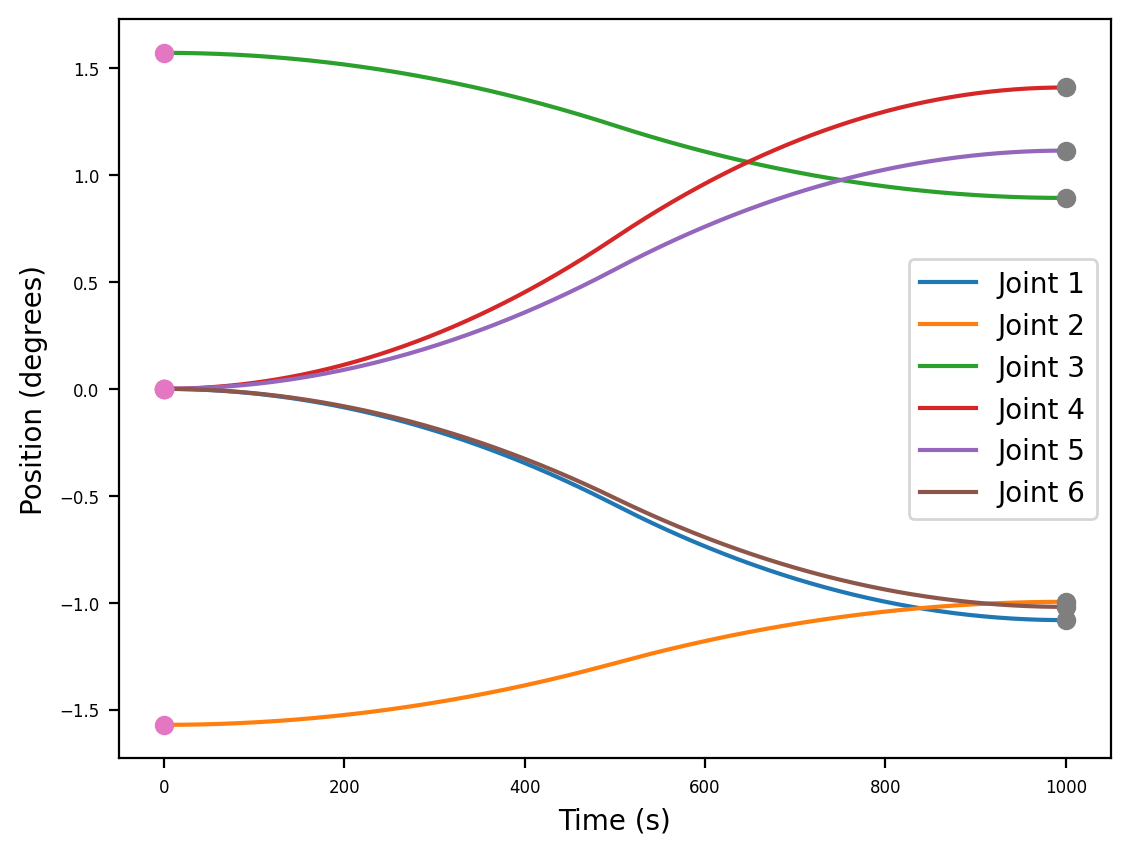

In [32]:
# Plotting joint positions over time
for i in range(q_list.shape[0]):
    plt.plot(np.arange(len(q_list.T)), q_list.T[:, i], label=f'Joint {i+1}')
plt.plot(np.zeros(6), q_init, 'o') #, label='Initial position')
plt.plot(np.ones(6) * (q_list.shape[-1]), q_final, 'o') # , label='Final position')
plt.xlabel('Time (s)')
plt.ylabel('Position (degrees)')
plt.legend()
plt.show()

In [34]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

p_curr_list = []

# Reset
env.reset()
env.forward(q=q_init,joint_idxs=[0,1,2,3,4,5])
tick,max_sec = 0,100
while env.get_sim_time() <= max_sec:
    # Step
    if tick >= q_list.shape[1]: 
        env.step(ctrl=q,ctrl_idxs=[0,1,2,3,4,5,6])
    else:
        q = np.append(np.array(q_list).T[tick,:],1.0) # open gripper
        env.step(ctrl=q,ctrl_idxs=[0,1,2,3,4,5,6])
    tick = min(tick + 1,q_list.shape[1]-1)
    if not env.is_viewer_alive(): break
    p_curr = env.get_p_body('tcp_link')
    p_curr_list.append(p_curr)

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=None,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

        # Save PCD
        pcd_tick += 1
        # for p in pcd: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,1])
        for p in p_curr_list[::30]: env.plot_sphere(p=np.array(p),r=0.005,rgba=[0.05,0.95,0.05,1])
        env.render(render_every=1)
        
# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

Pressed ESC
Quitting.
Done. Tick:[1302] Time:[2.60]sec
